In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# K-DRONE Optimization Pipeline

## Workflow:
1. **Data Loading** → Load titik_semprotan.csv, build distance matrix
2. **Clustering** → K-Means untuk bagi nodes ke K vehicles/zones
3. **Optimization** → 2-OPT, Lovebird GA, atau ILS untuk optimize per-cluster routes
4. **Visualization** → Plot clusters, routes, convergence history

## Helper Functions:
- `total_distance(tour)` - Hitung total jarak satu rute (circular)
- `plot_clusters()` - Visualisasi hasil K-Means
- `elbow_analysis()` - Tentukan K optimal
- `run_kmeans()` - Jalankan K-Means clustering


In [15]:
# === DATA LOADING & INITIALIZATION ===
# Load data dari CSV
df = pd.read_csv('titik_semprotan.csv')
ids = df['id'].tolist()
locations = df[['x', 'y']].values

# Build mappings untuk efficient lookup
id2idx = {i: k for k, i in enumerate(ids)}              # id -> index in locations
nodes = list(dict.fromkeys(ids))                        # unique IDs, order-preserving
idx = {node: k for k, node in enumerate(nodes)}         # node ID -> index in nodes

# === DISTANCE MATRIX (Vectorized) ===
# Bangun koordinat matrix sesuai urutan nodes
N = len(nodes)
coords = np.empty((N, 2), dtype=np.float64)
for k, node in enumerate(nodes):
    orig_idx = id2idx[node]
    coords[k] = locations[orig_idx]

# Hitung distance matrix sekali (O(N²), tapi bisa dipakai berkali-kali)
diff = coords[:, None, :] - coords[None, :, :]  # vectorized difference
D = np.sqrt((diff * diff).sum(axis=2))           # Euclidean distance
np.fill_diagonal(D, 0.0)                         # diagonal = 0

print(f"Data loaded: {N} points, distance matrix shape {D.shape}")

# === HELPER FUNCTIONS ===
def total_distance(tour):
    """Hitung total jarak satu tour (termasuk kembali ke awal)"""
    L = len(tour)
    if L < 2:
        return 0.0
    
    distance = sum(D[idx[tour[i]], idx[tour[i+1]]] for i in range(L - 1))
    distance += D[idx[tour[-1]], idx[tour[0]]]  # kembali ke awal
    return float(distance)

def split_ids(ids_list, num_vehicles):
    """Bagi IDs ke num_vehicles rute secara acak"""
    shuffled = ids_list[:]
    random.shuffle(shuffled)
    return [shuffled[i::num_vehicles] for i in range(num_vehicles)]

Data loaded: 135 points, distance matrix shape (135, 135)


# K Clustering

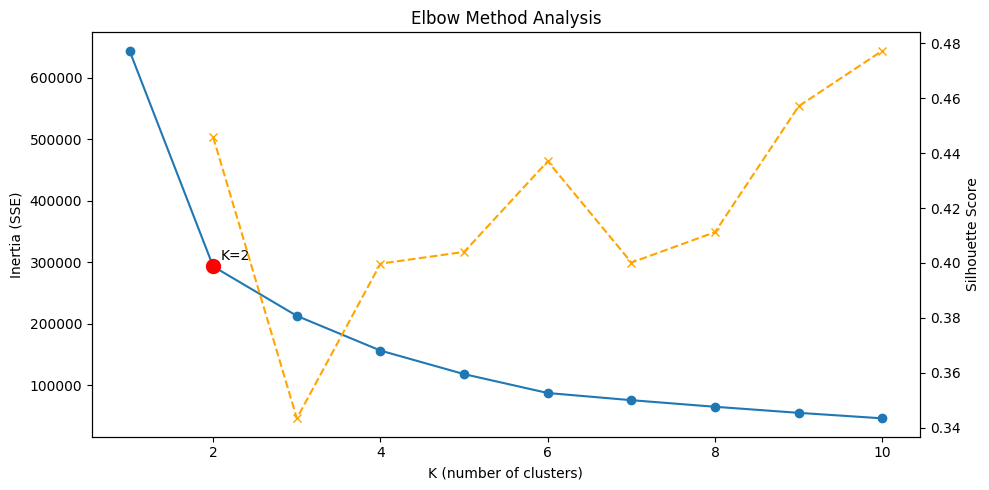

Recommended K: 2
Clusters: 2
  Cluster 0: 75 points
  Cluster 1: 60 points


In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def elbow_analysis(coords, k_min=1, k_max=10, random_state=42, n_init=10, show_plot=True):
    """
    Analisis elbow untuk menentukan jumlah cluster optimal.
    Menggunakan heuristik: K dengan penurunan inertia terbesar.
    """
    k_values = list(range(k_min, min(k_max, len(coords)) + 1))
    inertias, silhouettes = [], []

    # Hitung inertia dan silhouette untuk setiap K
    for k in k_values:
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        km.fit(coords)
        inertias.append(km.inertia_)
        if k >= 2:
            silhouettes.append(silhouette_score(coords, km.labels_))
        else:
            silhouettes.append(np.nan)

    # Heuristic: cari K dengan penurunan inertia terbesar
    best_k = k_values[0]
    if len(k_values) >= 3:
        drops = [(inertias[i-1] - inertias[i]) / max(inertias[i-1], 1e-9) 
                 for i in range(1, len(inertias))]
        best_k = k_values[np.argmax(drops) + 1]

    # Plot hasil (opsional)
    if show_plot:
        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax1.plot(k_values, inertias, marker='o', label='Inertia')
        ax1.set_xlabel('K (number of clusters)')
        ax1.set_ylabel('Inertia (SSE)')
        ax1.set_title('Elbow Method Analysis')
        
        # Tandai best K
        if best_k in k_values:
            best_idx = k_values.index(best_k)
            ax1.scatter([best_k], [inertias[best_idx]], s=100, color='red', zorder=5)
            ax1.annotate(f'K={best_k}', (best_k, inertias[best_idx]), 
                        xytext=(5, 5), textcoords='offset points')
        
        # Plot silhouette di sumbu kedua
        ax2 = ax1.twinx()
        ax2.plot(k_values, silhouettes, marker='x', linestyle='--', color='orange', label='Silhouette')
        ax2.set_ylabel('Silhouette Score')
        
        fig.tight_layout()
        plt.show()

    return {
        "k_values": k_values,
        "inertias": inertias,
        "silhouettes": silhouettes,
        "best_k": best_k
    }

def run_kmeans(coords, nodes, k, random_state=42, n_init=10):
    """
    Jalankan K-Means clustering dan return labels, clusters per group, dan centroids.
    """
    if k < 1 or k > len(coords):
        raise ValueError(f"k harus antara 1 dan {len(coords)}")
    
    km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    labels = km.fit_predict(coords)
    centroids = km.cluster_centers_

    # Kelompokkan nodes per cluster
    clusters = {c: [] for c in range(k)}
    for node, label in zip(nodes, labels):
        clusters[int(label)].append(node)

    return labels, clusters, centroids

def plot_clusters(coords, labels, centroids=None):
    """
    Visualisasi hasil clustering dengan scatter plot.
    Warna berbeda per cluster, centroid ditandai dengan segitiga.
    """
    labels = np.asarray(labels)
    k = int(labels.max()) + 1
    
    colors = plt.cm.Set3(np.linspace(0, 1, k))
    for c in range(k):
        pts = coords[labels == c]
        plt.scatter(pts[:, 0], pts[:, 1], label=f'Cluster {c}', color=colors[c], s=30, alpha=0.7)
    
    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', s=200, 
                   edgecolors='black', linewidths=1, color='red', label='Centroids', zorder=10)
    
    plt.legend()
    plt.title('K-Means Clustering Result')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# === Usage ===
info = elbow_analysis(coords, k_min=1, k_max=10, random_state=0, n_init=20, show_plot=True)
chosen_k = info["best_k"]
print(f"Recommended K: {chosen_k}")

labels, clusters, centroids = run_kmeans(coords, nodes, chosen_k)
print(f"Clusters: {chosen_k}")
for c, cluster_nodes in clusters.items():
    print(f"  Cluster {c}: {len(cluster_nodes)} points")

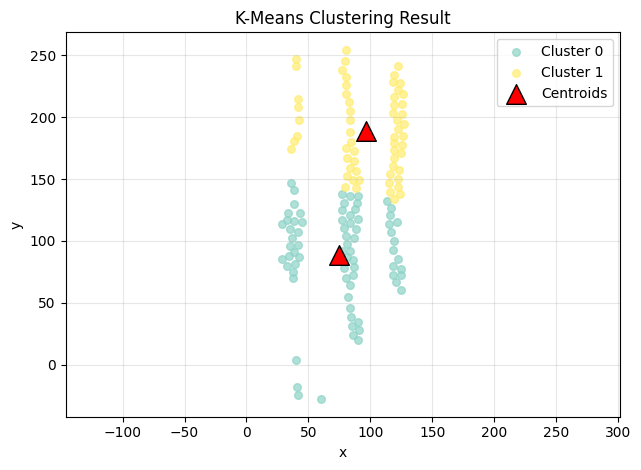

In [17]:
plot_clusters(coords, labels, centroids)

# Ortools for Benchmarking

In [18]:
# === OR-TOOLS VRP SOLVER (untuk benchmarking) ===
"""
Google OR-Tools VRP solver dengan multi-vehicle support.
Dipakai sebagai baseline/benchmark untuk membandingkan dengan metaheuristics.
"""

SCALE = 1000  # Precision scaling untuk integer distance matrix

def _build_distance_matrix(nodes_list, scale=SCALE):
    """Bangun integer distance matrix dari nodes (scaled untuk precision)"""
    N = len(nodes_list)
    return [[int(round(scale * float(D[idx[nodes_list[i]], idx[nodes_list[j]]])))
             for j in range(N)] for i in range(N)]

def _remap_labels_to_vehicles(labels, starts_ids):
    """Map cluster labels ke vehicle indices sesuai urutan starts_ids"""
    unique_labels = [labels[nodes.index(sid)] for sid in starts_ids]
    label_to_vehicle = {lbl: vid for vid, lbl in enumerate(unique_labels)}
    remapped = [label_to_vehicle[lbl] for lbl in labels]
    return remapped, label_to_vehicle

def create_data_model_clustered(nodes_list, labels, starts_ids, ends_ids=None, scale=SCALE):
    """
    Setup data model untuk OR-Tools VRP.
    
    Parameters:
    -----------
    nodes_list : list
        List ID nodes
    labels : array
        Cluster label per node (dari K-Means)
    starts_ids : list
        Starting node ID per vehicle
    ends_ids : list
        Ending node ID per vehicle (default = starts_ids for round-trip)
    """
    assert len(nodes_list) == len(labels), "nodes dan labels harus same length"
    
    K = len(starts_ids)
    if ends_ids is None:
        ends_ids = starts_ids[:]
    assert len(ends_ids) == K, "ends_ids harus same length dengan starts_ids"
    
    # Remap labels ke vehicle indices
    labels_remap, _ = _remap_labels_to_vehicles(labels, starts_ids)
    
    # Build distance matrix
    dist_matrix = _build_distance_matrix(nodes_list, scale=scale)
    
    # Node allowed vehicles (per cluster constraint)
    node_allowed = {i: [int(labels_remap[i])] for i in range(len(nodes_list))}
    
    # Convert starts/ends ke internal indices
    starts_idx = [nodes_list.index(x) for x in starts_ids]
    ends_idx = [nodes_list.index(x) for x in ends_ids]
    
    return {
        "distance_matrix": dist_matrix,
        "num_vehicles": K,
        "starts": starts_idx,
        "ends": ends_idx,
        "node_allowed_vehicles": node_allowed,
        "nodes": nodes_list,
        "scale": scale,
    }

def solve_vrp_clustered(nodes_list, labels, starts_ids, ends_ids=None, 
                        timeout_s=60, first_strategy="PATH_CHEAPEST_ARC",
                        metaheuristic="GUIDED_LOCAL_SEARCH"):
    """
    Solve clustered VRP menggunakan Google OR-Tools.
    
    Returns:
    --------
    routes_ids : list of lists
        Solusi routes (node IDs) per vehicle
    per_costs : list
        Cost per vehicle (float, unscaled)
    total_cost : float
        Total cost semua vehicle
    """
    data = create_data_model_clustered(nodes_list, labels, starts_ids, ends_ids)
    
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'],
                                           data['starts'],
                                           data['ends'])
    routing = pywrapcp.RoutingModel(manager)
    
    # Cost callback
    def distance_callback(from_idx, to_idx):
        f_node = manager.IndexToNode(from_idx)
        t_node = manager.IndexToNode(to_idx)
        return data['distance_matrix'][f_node][t_node]
    
    transit_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_idx)
    
    # Enforce cluster constraints
    for node_id in range(len(nodes_list)):
        node_idx = manager.NodeToIndex(node_id)
        routing.SetAllowedVehiclesForIndex(data['node_allowed_vehicles'][node_id], node_idx)
    
    # Search parameters
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.time_limit.seconds = int(timeout_s)
    search_params.first_solution_strategy = getattr(
        routing_enums_pb2.FirstSolutionStrategy, first_strategy)
    search_params.local_search_metaheuristic = getattr(
        routing_enums_pb2.LocalSearchMetaheuristic, metaheuristic)
    
    solution = routing.SolveWithParameters(search_params)
    if not solution:
        print("No solution found!")
        return None, [], float('inf')
    
    # Extract routes & costs
    routes_ids = []
    per_costs = []
    total_scaled = 0
    
    for v in range(data['num_vehicles']):
        index = routing.Start(v)
        route_idx = []
        while not routing.IsEnd(index):
            route_idx.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route_idx.append(manager.IndexToNode(index))
        
        # Convert to node IDs
        route_ids = [data['nodes'][i] for i in route_idx]
        routes_ids.append(route_ids)
        
        # Calculate cost
        cost_scaled = sum(data['distance_matrix'][route_idx[i]][route_idx[i+1]]
                         for i in range(len(route_idx)-1))
        total_scaled += cost_scaled
        per_costs.append(cost_scaled / float(data['scale']))
    
    total_cost = total_scaled / float(data['scale'])
    return routes_ids, per_costs, total_cost

def solve_vrp_random_starts(nodes_list, labels, timeout_s=60, seed=None, round_trip=True):
    """
    Solve VRP dengan random start points per cluster (benchmark cepat).
    """
    rng = random.Random(seed)
    K = int(max(labels)) + 1
    
    # Kumpulkan nodes per cluster
    clusters = {c: [] for c in range(K)}
    for n, lab in zip(nodes_list, labels):
        clusters[int(lab)].append(n)
    
    # Random start per cluster
    starts = [rng.choice(clusters[c]) for c in range(K)]
    ends = starts if round_trip else [rng.choice(clusters[c]) for c in range(K)]
    
    routes, per_costs, total_cost = solve_vrp_clustered(
        nodes_list, labels, starts, ends, timeout_s=timeout_s)
    
    return {
        "starts": starts,
        "routes": routes,
        "per_costs": per_costs,
        "total_cost": total_cost
    }

In [19]:
res = solve_vrp_random_starts(nodes, labels, timeout_s=20, seed=None)
print("Start per kluster:", res["starts"])
print("Biaya per kluster:", res["per_costs"])
print("Total cost:", res["total_cost"])
for i, r in enumerate(res["routes"], 1):
    print(f"Rute kendaraan {i}:", r)

Start per kluster: [67, 73]
Biaya per kluster: [739.159, 574.145]
Total cost: 1313.304
Rute kendaraan 1: [67, 123, 43, 50, 101, 130, 1, 71, 30, 55, 77, 20, 88, 47, 115, 76, 60, 16, 85, 6, 41, 108, 44, 128, 58, 18, 116, 69, 84, 8, 135, 53, 38, 78, 114, 90, 3, 82, 125, 59, 27, 51, 80, 10, 117, 52, 29, 54, 110, 106, 15, 93, 62, 132, 112, 96, 37, 81, 40, 72, 34, 107, 23, 63, 111, 133, 95, 4, 42, 103, 11, 26, 124, 21, 129, 67]
Rute kendaraan 2: [73, 122, 28, 87, 121, 109, 68, 118, 19, 46, 45, 61, 126, 100, 33, 89, 13, 131, 98, 119, 75, 48, 2, 127, 66, 32, 92, 12, 70, 120, 25, 64, 113, 104, 39, 74, 97, 5, 91, 36, 105, 24, 94, 49, 9, 99, 56, 17, 35, 79, 22, 86, 7, 65, 83, 31, 102, 14, 134, 57, 73]


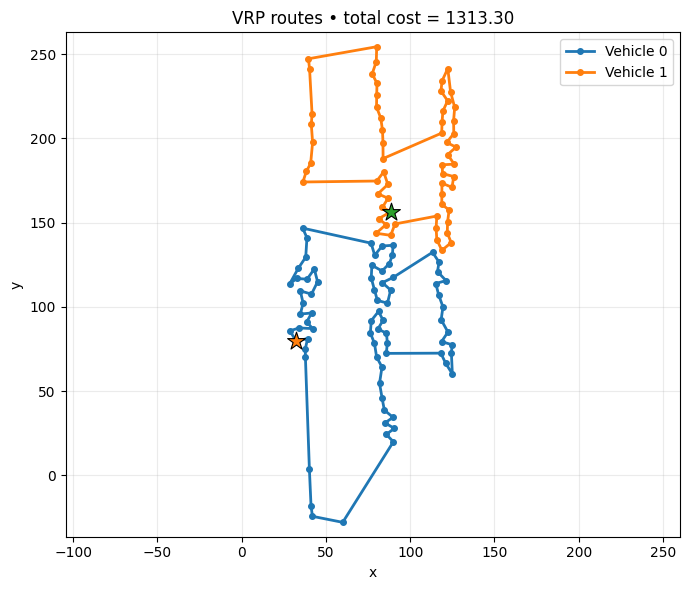

In [20]:
def _xy_of(node_id):
    # coords sejajar dengan `nodes`, dan `idx` memetakan id -> index
    return coords[idx[node_id], 0], coords[idx[node_id], 1]

def plot_routes_matplotlib(routes, starts=None, ends=None, show_ids=False, title="VRP routes"):
    fig, ax = plt.subplots(figsize=(7, 6))

    # plot semua titik sebagai background tipis
    ax.scatter(coords[:,0], coords[:,1], s=10, alpha=0.3, label="_all_points_bg")

    # gambar tiap rute
    for v, route in enumerate(routes):
        if len(route) == 0:
            continue

        # ambil koordinat sepanjang rute (termasuk node terakhir = end)
        xs, ys = [], []
        for nid in route:
            x, y = _xy_of(nid)
            xs.append(x); ys.append(y)

        # garis rutenya
        ax.plot(xs, ys, marker='o', linewidth=2, markersize=4, label=f"Vehicle {v}")

        # tandai start & end
        s_id = starts[v] if starts is not None else route[0]
        e_id = ends[v]   if ends is not None   else route[-1]
        sx, sy = _xy_of(s_id)
        ex, ey = _xy_of(e_id)

        ax.scatter([sx],[sy], marker='*', s=180, edgecolor='k', linewidths=0.8, zorder=5, label=f"_start_{v}")
        if e_id != s_id:
            ax.scatter([ex],[ey], marker='s', s=90, edgecolor='k', linewidths=0.8, zorder=5, label=f"_end_{v}")

        # optional: tulis ID di titik
        if show_ids:
            for nid in route:
                x, y = _xy_of(nid)
                ax.text(x, y, str(nid), fontsize=8, ha='right', va='bottom')

    ax.set_title(title)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.legend()
    ax.axis("equal")
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

plot_routes_matplotlib(
    routes=res["routes"],
    starts=res["starts"],
    ends=None,                # None -> otomatis dari list rute
    show_ids=False,
    title=f"VRP routes • total cost = {res['total_cost']:.2f}"
)

In [21]:
def plot_clustered_routes_matplotlib(cluster_routes, show_ids=False, title=None):
    fig, ax = plt.subplots(figsize=(7, 6))

    # background semua titik
    ax.scatter(coords[:,0], coords[:,1], s=10, alpha=0.25, label="_all_points_bg")

    for c, route in enumerate(cluster_routes):
        if not route:
            continue

        # urutan titik termasuk menutup ke awal (jika L>=2)
        xs, ys = [], []
        for nid in route:
            x, y = _xy_of(nid)
            xs.append(x); ys.append(y)
        if len(route) >= 2:
            x0, y0 = _xy_of(route[0])
            xs.append(x0); ys.append(y0)

        ax.plot(xs, ys, marker='o', linewidth=2, markersize=4, label=f"Cluster {c}")

        # tandai start (node pertama di list)
        sx, sy = _xy_of(route[0])
        ax.scatter([sx],[sy], marker='*', s=160, edgecolor='k', linewidths=0.8, zorder=5, label=f"_start_{c}")

        if show_ids:
            for nid in route:
                x, y = _xy_of(nid)
                ax.text(x, y, str(nid), fontsize=8, ha='right', va='bottom')

    if title is None:
        title = "Lovebird (clustered) routes"
    ax.set_title(title)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.legend()
    ax.axis("equal")
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

# Lovebird Initial Algorithm

In [22]:
# === Mutation operators untuk TSP ===
def swap_two(tour, i, j):
    """Swap: tukar dua segment jika distance > 4, else gunakan interchange"""
    new = tour[:]
    if j - i < 4:
        return interchange(new, i, j)
    
    mid = new[i:j+1]
    k = len(mid) // 2
    new[i:i+k] = mid[k:]
    new[i+k:j+1] = mid[:k]
    return new

def flip(tour, i, j):
    """2-OPT: reverse segment [i:j+1]"""
    new = tour[:]
    new[i:j+1] = reversed(new[i:j+1])
    return new

def interchange(tour, i, j):
    """Obverse swap: tukar dua node"""
    new = tour[:]
    new[i], new[j] = new[j], new[i]
    return new

def slide(tour, i, j):
    """Slide: pindahkan node i ke posisi j"""
    new = tour[:]
    city = new.pop(i)
    new.insert(j, city)
    return new

def guided_swap(tour, i, j):
    """Hybrid: kombinasi flip + interchange"""
    new = flip(tour, i, j)
    return interchange(new, i, j)

def scramble(tour):
    """Random shuffle: acak urutan seluruh tour"""
    new = tour[:]
    random.shuffle(new)
    return new

In [50]:
# === Helper functions untuk Lovebird Algorithm ===

def roulette_wheel(population, fitness):
    """Selection: pilih individu dengan probabilitas sesuai fitness (1/cost)"""
    total = sum(fitness)
    spin = random.uniform(0, total)
    acc = 0
    for individual, fit in zip(population, fitness):
        acc += fit
        if acc >= spin:
            return individual
    return population[-1]

def _clusters_from_labels(nodes, labels):
    """
    Convert labels ke dictionary mapping cluster -> list of nodes.
    Nodes dalam cluster dijaga urutan sesuai input.
    """
    K = int(max(labels)) + 1
    clusters = {c: [] for c in range(K)}
    for node, label in zip(nodes, labels):
        clusters[int(label)].append(node)
    return clusters, K

def _apply_mutation(tour, i, j, op_type):
    """
    Apply mutation operator berdasar tipe:
    1=swap_two, 2=flip, 3=interchange, 4=slide, 5=guided_swap
    """
    if op_type == 1:
        return swap_two(tour, i, j)
    elif op_type == 2:
        return flip(tour, i, j)
    elif op_type == 3:
        return interchange(tour, i, j)
    elif op_type == 4:
        return slide(tour, i, j)
    else:
        return guided_swap(tour, i, j)

def _calculate_multi_route_cost(routes):
    """Hitung total cost untuk solusi multi-route (per cluster)"""
    return sum(total_distance(r) for r in routes)

In [24]:
def lovebird_algorithm_clustered(labels, nodes, maxGeneration=10, popSize=10, seed=None):
    """
    Lovebird Algorithm untuk multi-cluster TSP.
    Setiap cluster dioptimalkan per rute, tanpa perpindahan cross-cluster.
    
    Parameters:
    -----------
    labels : array
        Cluster label per node (dari K-Means)
    nodes : list
        List node IDs
    maxGeneration : int
        Jumlah generasi GA
    popSize : int
        Ukuran populasi
    seed : int, optional
        Random seed untuk reproducibility
        
    Returns:
    --------
    best_solution : list of lists
        Rute terbaik per cluster
    best_fitness : float
        Total jarak terbaik
    history : list
        Perkembangan fitness per generasi
    per_cluster_costs : list
        Cost per cluster
    """
    rng = random.Random(seed)
    EPS = 1e-12

    # Build cluster mapping
    cluster_nodes, K = _clusters_from_labels(nodes, labels)

    # === Initialize population ===
    def _random_individual():
        """Buat individu: random permutasi per cluster"""
        indiv = []
        for c in range(K):
            route = cluster_nodes[c][:]
            rng.shuffle(route)
            indiv.append(route)
        return indiv

    population = [_random_individual() for _ in range(popSize)]
    pop_costs = [_calculate_multi_route_cost(ind) for ind in population]

    # Track best
    best_idx = min(range(popSize), key=lambda i: pop_costs[i])
    best_solution = [r[:] for r in population[best_idx]]
    best_fitness = pop_costs[best_idx]
    history = [best_fitness]

    # === GA Loop ===
    for gen in range(maxGeneration):
        # Selection: roulette wheel
        fitness_values = [1.0/c if c > 0 else 1e9 for c in pop_costs]
        
        new_population = []
        new_costs = []

        for _ in range(popSize):
            # Select parent
            parent = roulette_wheel(population, fitness_values)
            child = [r[:] for r in parent]

            # Mutation: random cluster + random operator
            if K > 0:
                v = rng.randrange(K)
                route = child[v]
                
                if len(route) >= 2:
                    if rng.random() < 0.9:
                        # Apply random mutation operator
                        i, j = sorted(rng.sample(range(len(route)), 2))
                        op = rng.choice([swap_two, flip, interchange, slide, guided_swap])
                        child[v] = op(route, i, j)
                    else:
                        # Scramble
                        child[v] = scramble(route)

            # Calculate cost
            child_cost = _calculate_multi_route_cost(child)
            new_population.append(child)
            new_costs.append(child_cost)

        # Elitism: keep best
        gen_best_idx = min(range(popSize), key=lambda i: new_costs[i])
        if new_costs[gen_best_idx] < best_fitness - EPS:
            best_fitness = new_costs[gen_best_idx]
            best_solution = [r[:] for r in new_population[gen_best_idx]]

        population = new_population
        pop_costs = new_costs
        history.append(best_fitness)

    # Calculate per-cluster costs
    per_cluster_costs = [total_distance(r) for r in best_solution]
    best_fitness = float(sum(per_cluster_costs))
    
    return best_solution, best_fitness, history, per_cluster_costs

In [25]:
# labels = ...   # hasil KMeans, sejajar dengan nodes
best_sol_l, total_cost_l, hist_l, per_costs_l = lovebird_algorithm_clustered(
    labels, nodes, maxGeneration=10, popSize=10
)

print("Biaya per kluster:", per_costs_l)
print("Total biaya:", total_cost_l)
for i, r in enumerate(best_sol_l, 1):
    print(f"Rute kluster {i} (|r|={len(r)}):", r)

Biaya per kluster: [4430.919601483549, 3018.3638300250223]
Total biaya: 7449.283431508571
Rute kluster 1 (|r|=75): [16, 135, 76, 38, 11, 133, 72, 106, 112, 103, 18, 90, 96, 51, 115, 67, 123, 71, 40, 114, 60, 130, 77, 10, 43, 124, 95, 82, 128, 53, 8, 15, 78, 107, 62, 110, 4, 69, 20, 84, 29, 116, 27, 117, 52, 132, 59, 3, 6, 111, 1, 101, 34, 80, 41, 26, 55, 42, 37, 47, 85, 81, 30, 23, 93, 21, 108, 54, 50, 58, 125, 129, 88, 63, 44]
Rute kluster 2 (|r|=60): [113, 13, 100, 131, 121, 98, 28, 33, 119, 36, 91, 73, 19, 12, 17, 120, 102, 70, 24, 92, 5, 75, 64, 25, 9, 94, 32, 122, 87, 104, 127, 61, 48, 118, 134, 68, 2, 83, 31, 45, 14, 105, 46, 74, 86, 65, 57, 109, 22, 97, 49, 35, 126, 39, 7, 66, 99, 56, 89, 79]


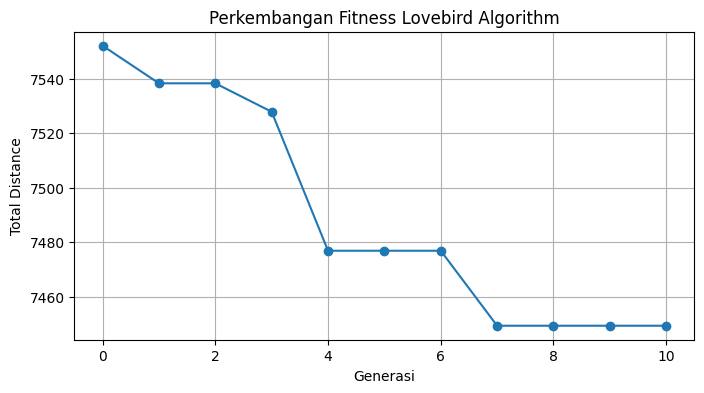

In [26]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_l, marker='o')
plt.title("Perkembangan Fitness Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

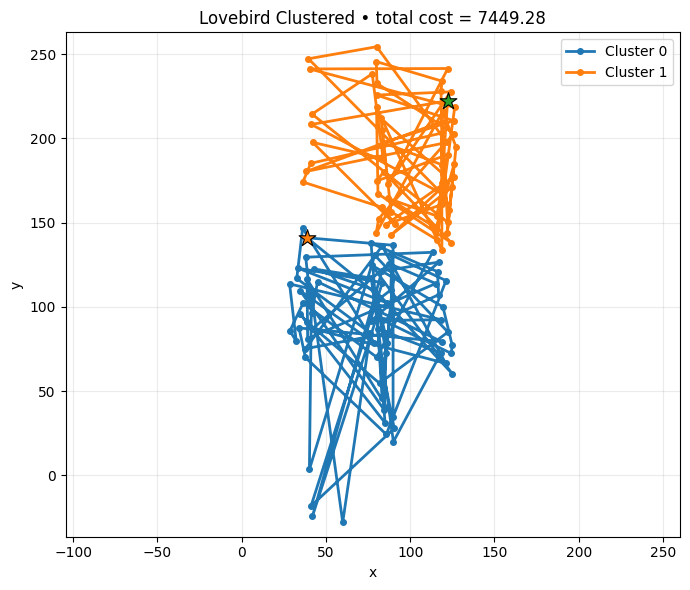

In [27]:
# --- contoh pakai hasil lovebird ---
plot_clustered_routes_matplotlib(
    best_sol_l,
    show_ids=False,
    title=f"Lovebird Clustered • total cost = {total_cost_l:.2f}"
)

# Local Search Algorithm

In [ ]:
def two_opt_local_search(
    maxLoop=100,
    clusters=None,
    labels=None, nodes=None,
    initial_solution=None,
    time_budget=None,
    check_every=4096
):

    # === Time control ===
    t0 = time.perf_counter()
    def time_up():
        return (time_budget is not None) and ((time.perf_counter() - t0) >= time_budget)

    # === Initialize solution (pilih source dengan prioritas) ===
    if clusters is not None:
        current = [r[:] for r in clusters if len(r) > 0]
    elif (labels is not None) and (nodes is not None):
        # Dari hasil K-Means: kumpulkan nodes per cluster
        lab = np.asarray(labels)
        K = int(lab.max()) + 1 if lab.size > 0 else 0
        cluster_dict = {c: [] for c in range(K)}
        for node, label in zip(nodes, lab):
            cluster_dict[int(label)].append(node)
        
        # Randomisasi urutan dalam setiap cluster
        current = []
        for c in range(K):
            if cluster_dict[c]:
                route = cluster_dict[c][:]
                random.shuffle(route)
                current.append(route)
    elif initial_solution is not None:
        current = [r[:] for r in initial_solution if len(r) > 0]
    else:
        # Fallback: single vehicle dengan semua nodes
        shuffled = ids[:]
        random.shuffle(shuffled)
        current = [shuffled]

    if len(current) == 0:
        return [], 0.0, [0.0], []

    # === Track best solution ===
    route_costs = [total_distance(r) for r in current]
    total_cost = float(sum(route_costs))
    best_solution = [r[:] for r in current]
    best_cost = total_cost
    history = [best_cost]

    EPS = 1e-12
    ops_count = 0

    # === 2-OPT local search: minimize dengan 2-edge exchange ===
    def improve_single_route(route):
        """
        Apply 2-OPT sampai tidak ada perbaikan pada satu route.
        Return: delta cost yang sudah terakumulasi
        """
        L = len(route)
        if L <= 2:
            return 0.0
        
        total_delta = 0.0
        improved = True
        
        while improved:
            improved = False
            accepted = False
            
            # First-improvement: terima perbaikan pertama yang ditemukan
            i = 0
            while i < L - 1 and not accepted:
                j = i + 1
                while j < L and not accepted:
                    # Time budget throttling
                    nonlocal ops_count
                    ops_count += 1
                    if (ops_count % check_every == 0) and time_up():
                        return total_delta  # keluar dengan delta yang sudah terkumpul
                    
                    # Skip jika potong edge yang sama (circular tour)
                    if i == 0 and j == L - 1:
                        j += 1
                        continue
                    
                    # Hitung delta untuk 2-opt swap
                    # Remove edges (i-1, i) dan (j, j+1)
                    # Add edges (i-1, j) dan (i, j+1)
                    ap = route[(i - 1) % L]
                    a = route[i]
                    c = route[j]
                    dn = route[(j + 1) % L]
                    
                    old_dist = D[idx[ap], idx[a]] + D[idx[c], idx[dn]]
                    new_dist = D[idx[ap], idx[c]] + D[idx[a], idx[dn]]
                    delta = new_dist - old_dist
                    
                    if delta < -EPS:  # Improvement found
                        route[i:j+1] = reversed(route[i:j+1])
                        total_delta += delta
                        improved = True
                        accepted = True
                    else:
                        j += 1
                
                if not accepted:
                    i += 1
        
        return total_delta

    # === Main optimization loop ===
    for iteration in range(maxLoop):
        if time_up():
            break
        
        # Improve SEMUA route sampai lokal optimum
        any_improved = True
        while any_improved and (not time_up()):
            any_improved = False
            for v in range(len(current)):
                if time_up():
                    break
                
                delta = improve_single_route(current[v])
                if abs(delta) > EPS:
                    route_costs[v] += delta
                    total_cost += delta
                    any_improved = True
        
        # Update best solution
        if total_cost < best_cost - EPS:
            best_cost = float(total_cost)
            best_solution = [r[:] for r in current]
        
        if time_up():
            break
        
        # Recompute & track history
        route_costs = [total_distance(r) for r in current]
        total_cost = float(sum(route_costs))
        history.append(best_cost)
    
    per_cluster_costs = [total_distance(r) for r in best_solution]
    best_cost = float(sum(per_cluster_costs))
    
    return best_solution, best_cost, history, per_cluster_costs

In [29]:
best_sol_ll, total_cost_ll, hist_ll, per_costs_ll = two_opt_local_search(
    maxLoop=20,
    labels=labels,
    nodes=nodes,
    time_budget=None
)

print("Biaya per kluster:", per_costs_ll)
print("Total biaya:", total_cost_ll)
for i, r in enumerate(best_sol_ll, 1):
    print(f"Rute kluster {i} (|r|={len(r)}):", r)

Biaya per kluster: [775.352532407175, 587.2898786236508]
Total biaya: 1362.6424110308258
Rute kluster 1 (|r|=75): [116, 18, 58, 78, 53, 38, 84, 8, 135, 112, 132, 96, 37, 62, 93, 15, 81, 106, 40, 72, 34, 107, 23, 26, 11, 103, 42, 4, 95, 133, 111, 63, 29, 54, 52, 117, 110, 10, 80, 51, 27, 59, 125, 82, 3, 90, 114, 128, 44, 108, 41, 6, 85, 16, 60, 76, 115, 47, 88, 20, 77, 55, 30, 71, 1, 43, 123, 67, 124, 21, 129, 50, 101, 130, 69]
Rute kluster 2 (|r|=60): [36, 91, 5, 97, 64, 25, 120, 70, 113, 12, 104, 92, 39, 74, 32, 66, 127, 2, 48, 75, 119, 13, 98, 131, 89, 33, 100, 68, 126, 61, 45, 46, 19, 118, 109, 28, 121, 87, 122, 73, 57, 134, 14, 102, 31, 83, 65, 7, 86, 22, 79, 35, 17, 56, 99, 9, 49, 94, 24, 105]


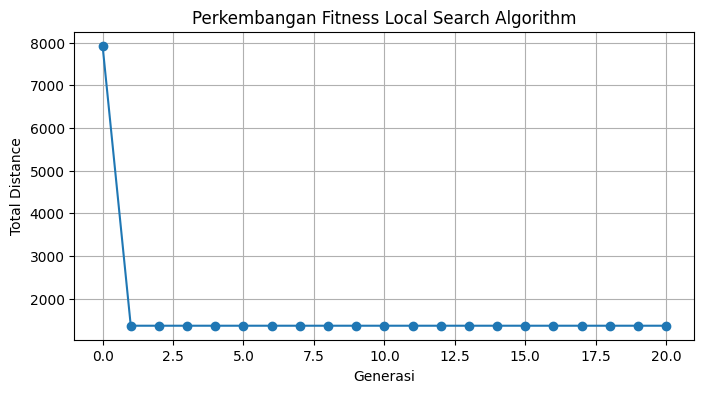

In [30]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_ll, marker='o')
plt.title("Perkembangan Fitness Local Search Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

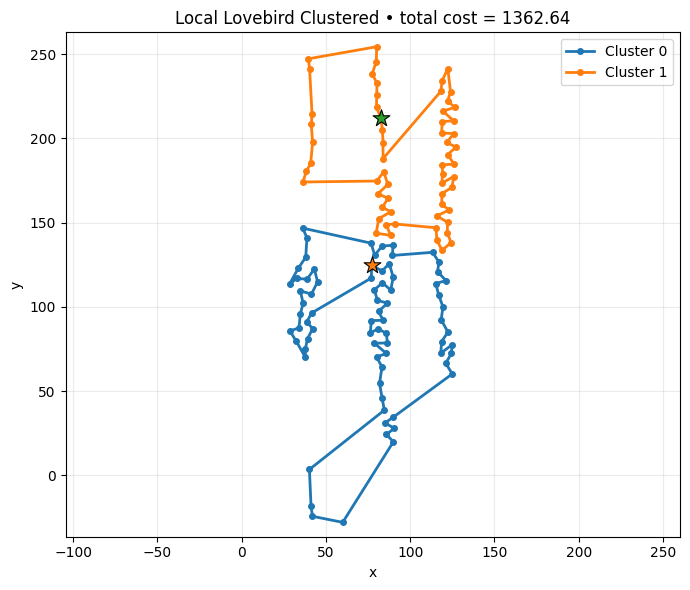

In [31]:
# --- contoh pakai hasil lovebird ---
plot_clustered_routes_matplotlib(
    best_sol_ll,
    show_ids=False,
    title=f"Local Lovebird Clustered • total cost = {total_cost_ll:.2f}"
)

# Iterated Lovebird Algorithm

In [ ]:
def double_bridge(route):
    L = len(route)
    if L < 8:
        return route[:]  # sama seperti semula
    rnd = random
    i1, i2, i3, i4 = sorted(rnd.sample(range(L), 4))
    segA = route[:i1]
    segB = route[i1:i2]
    segC = route[i2:i3]
    segD = route[i3:i4]
    segE = route[i4:]
    # varian klasik (tidak diubah)
    return segA + segC + segB + segD + segE

In [33]:
def double_bridge_multi(solution, min_len=8):
    """Terapkan double-bridge ke satu rute dalam solusi multi-rute."""
    new_sol = [r[:] for r in solution]
    rnd = random

    # pilih rute yang kandidat (panjang >= min_len)
    cand = [i for i, r in enumerate(new_sol) if len(r) >= min_len]
    if not cand:
        # fallback: kalau semua pendek, coba minimal len >= 4
        cand = [i for i, r in enumerate(new_sol) if len(r) >= 4]
        if not cand:
            return new_sol  # gak ada yang bisa di-double-bridge

    v = rnd.choice(cand)
    new_sol[v] = double_bridge(new_sol[v])  # pakai fungsi double_bridge lama milikmu
    return new_sol


In [34]:
def iterated_lovebird(
    max_iter=30,
    local_gen=120,
    clusters=None,
    labels=None, nodes=None,
    initial_solution=None,
    seed=None,
    budget_s=None,
    init_mutations=20
):
    """Iterated Local Search dengan operator perturbasi: double-bridge multi-route."""
    if seed is not None:
        random.seed(seed)

    def _init_solution_from_inputs():
        if clusters is not None:
            cur = [r[:] for r in clusters if len(r) > 0]
            return cur if cur else [[]]
        elif (labels is not None) and (nodes is not None):
            lab_arr = np.asarray(labels)
            K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
            tmp = {c: [] for c in range(K)}
            for n, l in zip(nodes, lab_arr):
                tmp[int(l)].append(n)
            cur = []
            for c in range(K):
                if tmp[c]:
                    r = tmp[c][:]
                    random.shuffle(r)
                    cur.append(r)
            return cur if cur else [[]]
        elif initial_solution is not None:
            return [r[:] for r in initial_solution if len(r) > 0] or [[]]
        else:
            ids_copy = ids[:]
            random.shuffle(ids_copy)
            return [ids_copy]

    ls = two_opt_local_search

    SAFETY = 0.05
    t_start = time.perf_counter()
    deadline = (t_start + budget_s) if (budget_s is not None) else None

    def time_left():
        return None if deadline is None else max(0.0, deadline - time.perf_counter())

    # === 1) Initial solution ===
    start_solution = _init_solution_from_inputs()
    rem = time_left()
    if rem is not None and rem <= SAFETY:
        best_sol = [r[:] for r in start_solution]
        best_cost = sum(total_distance(r) for r in best_sol)
        return best_sol, float(best_cost), [float(best_cost)]

    # === 2) Lovebird mutation phase (opsional) ===
    best_seed = [r[:] for r in start_solution]
    best_seed_cost = sum(total_distance(r) for r in best_seed)

    lovebird_ops = [swap_two, flip, interchange, slide, guided_swap]
    for _ in range(init_mutations):
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break
        
        cand = [r[:] for r in start_solution]
        route_indices = [i for i, r in enumerate(cand) if len(r) >= 2]
        if not route_indices:
            break
        
        v = random.choice(route_indices)
        route = cand[v][:]
        
        if random.random() < 0.9:
            L = len(route)
            if L >= 2:
                i, j = sorted(random.sample(range(L), 2))
                op = random.choice(lovebird_ops)
                new_route = op(route, i, j)
            else:
                continue
        else:
            new_route = scramble(route)
        
        cand[v] = new_route
        cand_cost = sum(total_distance(r) for r in cand)
        
        if cand_cost < best_seed_cost - 1e-9:
            best_seed = cand
            best_seed_cost = cand_cost

    # === 3) Local search awal ===
    rem = time_left()
    if rem is not None and rem <= SAFETY:
        best_sol = [r[:] for r in best_seed]
        best_cost = sum(total_distance(r) for r in best_sol)
        return best_sol, float(best_cost), [float(best_cost)]

    best_sol, best_cost, _hist0, _ = ls(
        maxLoop=local_gen,
        clusters=best_seed,
        time_budget=(rem - SAFETY) if rem is not None else None
    )
    history = [best_cost]

    # === 4) Pure ILS loop ===
    for _ in range(max_iter):
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        perturbed = double_bridge_multi(best_sol)

        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        imp_sol, imp_cost, _, _ = ls(
            maxLoop=local_gen,
            clusters=perturbed,
            time_budget=(rem - SAFETY) if rem is not None else None
        )

        if imp_cost < best_cost - 1e-9:
            best_sol = [r[:] for r in imp_sol]
            best_cost = imp_cost

        history.append(best_cost)

    return best_sol, float(best_cost), history

In [35]:
best_sol_il, best_cost_il, hist_il = iterated_lovebird(
    max_iter=100, local_gen=10,
    labels=labels, nodes=nodes,
    budget_s=20.0
)

# Ringkasan biaya
per_costs_il = [total_distance(r) for r in best_sol_il]  # biaya per kluster
total_cost_il = sum(per_costs_il)                         # sama dengan best_cost (cek konsistensi)

print("Biaya per kluster:", per_costs_il)
print("Total biaya (sum):", total_cost_il)
print("Total biaya (best_cost dari ILS):", best_cost_il)

# Cetak rute per kluster
for i, r in enumerate(best_sol_il, 1):
    print(f"Rute kluster {i} (|r|={len(r)}): {r}")

Biaya per kluster: [766.9986546550838, 575.2445038086513]
Total biaya (sum): 1342.2431584637352
Total biaya (best_cost dari ILS): 1342.2431584637352
Rute kluster 1 (|r|=75): [27, 51, 80, 10, 117, 52, 110, 54, 29, 133, 95, 4, 42, 103, 11, 26, 111, 63, 23, 107, 34, 72, 40, 106, 15, 93, 81, 37, 62, 96, 132, 112, 8, 135, 53, 78, 58, 18, 38, 84, 69, 116, 20, 88, 77, 55, 130, 50, 129, 21, 124, 67, 123, 43, 101, 1, 71, 30, 115, 47, 76, 60, 16, 85, 6, 41, 108, 44, 128, 114, 90, 3, 82, 125, 59]
Rute kluster 2 (|r|=60): [46, 19, 118, 68, 109, 121, 87, 28, 122, 73, 57, 134, 14, 65, 7, 86, 22, 79, 35, 17, 56, 99, 9, 49, 94, 24, 105, 36, 91, 5, 97, 31, 83, 102, 119, 75, 2, 66, 74, 39, 104, 113, 64, 25, 120, 70, 12, 92, 32, 127, 48, 98, 131, 13, 89, 33, 100, 126, 61, 45]


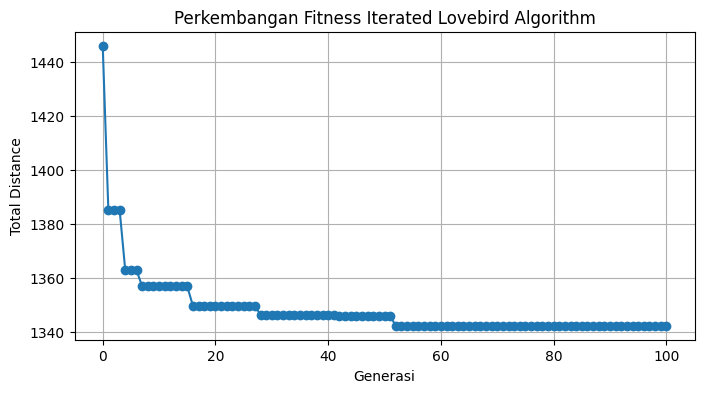

In [36]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_il, marker='o')
plt.title("Perkembangan Fitness Iterated Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

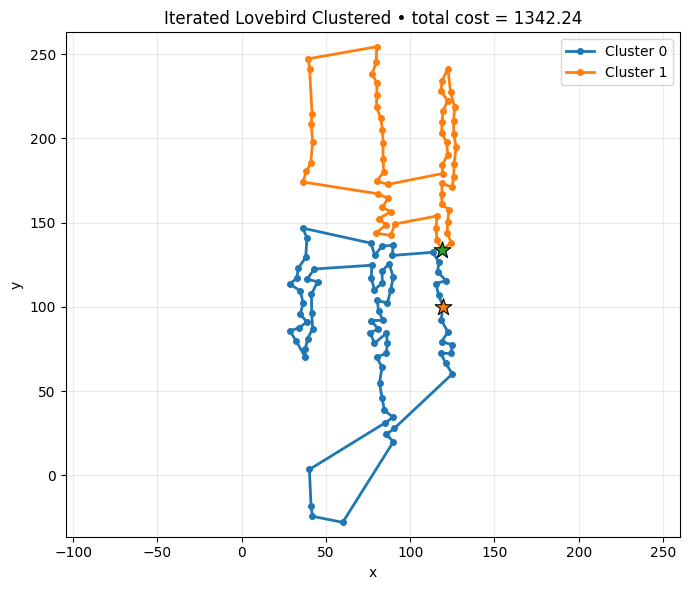

In [37]:
# --- contoh pakai hasil lovebird ---
plot_clustered_routes_matplotlib(
    best_sol_il,
    show_ids=False,
    title=f"Iterated Lovebird Clustered • total cost = {best_cost_il:.2f}"
)

## ILS DEBUGGING

In [38]:
def iterated_lovebird_debug(
    max_iter=30,
    local_gen=120,
    clusters=None,
    labels=None, nodes=None,
    initial_solution=None,
    seed=None,
    budget_s=None,
    init_mutations=20
):
    """Debug version of iterated_lovebird dengan logging detail per iterasi."""
    if seed is not None:
        random.seed(seed)

    def _init_solution_from_inputs():
        if clusters is not None:
            cur = [r[:] for r in clusters if len(r) > 0]
            return cur if cur else [[]]
        elif (labels is not None) and (nodes is not None):
            lab_arr = np.asarray(labels)
            K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
            tmp = {c: [] for c in range(K)}
            for n, l in zip(nodes, lab_arr):
                tmp[int(l)].append(n)
            cur = []
            for c in range(K):
                if tmp[c]:
                    r = tmp[c][:]
                    random.shuffle(r)
                    cur.append(r)
            return cur if cur else [[]]
        elif initial_solution is not None:
            return [r[:] for r in initial_solution if len(r) > 0] or [[]]
        else:
            ids_copy = ids[:]
            random.shuffle(ids_copy)
            return [ids_copy]

    ls = two_opt_local_search

    SAFETY = 0.05
    t_start = time.perf_counter()
    deadline = (t_start + budget_s) if (budget_s is not None) else None

    def time_left():
        return None if deadline is None else max(0.0, deadline - time.perf_counter())

    # === 1) Initial solution ===
    start_solution = _init_solution_from_inputs()
    rem = time_left()
    if rem is not None and rem <= SAFETY:
        best_sol = [r[:] for r in start_solution]
        best_cost = sum(total_distance(r) for r in best_sol)
        return best_sol, float(best_cost), [float(best_cost)], []

    # === 2) Lovebird mutation phase ===
    best_seed = [r[:] for r in start_solution]
    best_seed_cost = sum(total_distance(r) for r in best_seed)

    lovebird_ops = [swap_two, flip, interchange, slide, guided_swap]
    for _ in range(init_mutations):
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break
        
        cand = [r[:] for r in start_solution]
        route_indices = [i for i, r in enumerate(cand) if len(r) >= 2]
        if not route_indices:
            break
        
        v = random.choice(route_indices)
        route = cand[v][:]
        
        if random.random() < 0.9:
            L = len(route)
            if L >= 2:
                i, j = sorted(random.sample(range(L), 2))
                op = random.choice(lovebird_ops)
                new_route = op(route, i, j)
            else:
                continue
        else:
            new_route = scramble(route)
        
        cand[v] = new_route
        cand_cost = sum(total_distance(r) for r in cand)
        
        if cand_cost < best_seed_cost - 1e-9:
            best_seed = cand
            best_seed_cost = cand_cost

    # === 3) Local search awal ===
    rem = time_left()
    if rem is not None and rem <= SAFETY:
        best_sol = [r[:] for r in best_seed]
        best_cost = sum(total_distance(r) for r in best_sol)
        return best_sol, float(best_cost), [float(best_cost)], []

    best_sol, best_cost, _hist0, _ = ls(
        maxLoop=local_gen,
        clusters=best_seed,
        time_budget=(rem - SAFETY) if rem is not None else None
    )
    history = [best_cost]

    # === 4) ILS loop dengan logging ===
    iter_logs = []
    for it in range(1, max_iter + 1):
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        best_cost_before = best_cost
        perturbed = double_bridge_multi(best_sol)
        pert_cost = sum(total_distance(r) for r in perturbed)

        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        imp_sol, imp_cost, _, _ = ls(
            maxLoop=local_gen,
            clusters=perturbed,
            time_budget=(rem - SAFETY) if rem is not None else None
        )

        accepted = False
        if imp_cost < best_cost - 1e-9:
            best_sol = [r[:] for r in imp_sol]
            best_cost = imp_cost
            accepted = True

        history.append(best_cost)
        iter_logs.append({
            "iter": it,
            "time": time.perf_counter() - t_start,
            "best_before": float(best_cost_before),
            "pert_cost": float(pert_cost),
            "imp_cost": float(imp_cost),
            "best_after": float(best_cost),
            "accepted": bool(accepted),
        })

        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

    return best_sol, float(best_cost), history, iter_logs

In [39]:
best_sol, best_cost, history, logs = iterated_lovebird_debug(
    max_iter=500,
    local_gen=5,
    labels=labels,
    nodes=nodes,
    budget_s=None,
    init_mutations=20,
    seed=42  # biar repeatable
)

print("Final cost:", best_cost)
for entry in logs:
    print(
        f"iter={entry['iter']:2d} "
        f"best_before={entry['best_before']:.2f} "
        f"pert={entry['pert_cost']:.2f} "
        f"imp={entry['imp_cost']:.2f} "
        f"best_after={entry['best_after']:.2f} "
        f"accepted={entry['accepted']}"
    )

Final cost: 1309.4467394256365
iter= 1 best_before=1340.86 pert=1422.42 imp=1340.86 best_after=1340.86 accepted=False
iter= 2 best_before=1340.86 pert=1377.77 imp=1343.22 best_after=1340.86 accepted=False
iter= 3 best_before=1340.86 pert=1407.00 imp=1341.64 best_after=1340.86 accepted=False
iter= 4 best_before=1340.86 pert=1443.39 imp=1343.52 best_after=1340.86 accepted=False
iter= 5 best_before=1340.86 pert=1415.27 imp=1340.86 best_after=1340.86 accepted=False
iter= 6 best_before=1340.86 pert=1450.04 imp=1343.25 best_after=1340.86 accepted=False
iter= 7 best_before=1340.86 pert=1416.28 imp=1340.86 best_after=1340.86 accepted=False
iter= 8 best_before=1340.86 pert=1494.67 imp=1343.25 best_after=1340.86 accepted=False
iter= 9 best_before=1340.86 pert=1537.32 imp=1336.98 best_after=1336.98 accepted=True
iter=10 best_before=1336.98 pert=1499.57 imp=1352.34 best_after=1336.98 accepted=False
iter=11 best_before=1336.98 pert=1579.74 imp=1334.96 best_after=1334.96 accepted=True
iter=12 best_b

# Adaptive Iterated Lovebird Algorithm

In [41]:
def hyper_iterated_lovebird(
    max_iter=30,
    local_gen=120,
    clusters=None,
    labels=None, nodes=None,
    initial_solution=None,
    seed=None,
    budget_s=None,
    init_mutations=20,
    patience=3,
    max_level=5
):
    """Adaptive Iterated Lovebird: perturbasi level meningkat saat stagnan."""
    if seed is not None:
        random.seed(seed)

    def _init_solution_from_inputs():
        if clusters is not None:
            cur = [r[:] for r in clusters if len(r) > 0]
            return cur if cur else [[]]
        elif (labels is not None) and (nodes is not None):
            lab_arr = np.asarray(labels)
            K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
            tmp = {c: [] for c in range(K)}
            for n, l in zip(nodes, lab_arr):
                tmp[int(l)].append(n)
            cur = []
            for c in range(K):
                if tmp[c]:
                    r = tmp[c][:]
                    random.shuffle(r)
                    cur.append(r)
            return cur if cur else [[]]
        elif initial_solution is not None:
            return [r[:] for r in initial_solution if len(r) > 0] or [[]]
        else:
            ids_copy = ids[:]
            random.shuffle(ids_copy)
            return [ids_copy]

    ls = two_opt_local_search

    SAFETY = 0.05
    t_start = time.perf_counter()
    deadline = (t_start + budget_s) if (budget_s is not None) else None

    def time_left():
        return None if deadline is None else max(0.0, deadline - time.perf_counter())

    # === 1) Initial solution ===
    start_solution = _init_solution_from_inputs()
    rem = time_left()
    if rem is not None and rem <= SAFETY:
        best_sol = [r[:] for r in start_solution]
        best_cost = sum(total_distance(r) for r in best_sol)
        return best_sol, float(best_cost), [float(best_cost)]

    # === 2) Lovebird mutation phase ===
    best_seed = [r[:] for r in start_solution]
    best_seed_cost = sum(total_distance(r) for r in best_seed)

    lovebird_ops = [swap_two, flip, interchange, slide, guided_swap]
    for _ in range(init_mutations):
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break
        
        cand = [r[:] for r in start_solution]
        route_indices = [i for i, r in enumerate(cand) if len(r) >= 2]
        if not route_indices:
            break
        
        v = random.choice(route_indices)
        route = cand[v][:]
        
        if random.random() < 0.9:
            L = len(route)
            if L >= 2:
                i, j = sorted(random.sample(range(L), 2))
                op = random.choice(lovebird_ops)
                new_route = op(route, i, j)
            else:
                continue
        else:
            new_route = scramble(route)
        
        cand[v] = new_route
        cand_cost = sum(total_distance(r) for r in cand)
        
        if cand_cost < best_seed_cost - 1e-9:
            best_seed = cand
            best_seed_cost = cand_cost

    # === 3) Local search awal ===
    rem = time_left()
    if rem is not None and rem <= SAFETY:
        best_sol = [r[:] for r in best_seed]
        best_cost = sum(total_distance(r) for r in best_sol)
        return best_sol, float(best_cost), [float(best_cost)]

    best_sol, best_cost, _hist0, _ = ls(
        maxLoop=local_gen,
        clusters=best_seed,
        time_budget=(rem - SAFETY) if rem is not None else None
    )
    history = [best_cost]

    # === 4) Adaptive ILS loop: level perturbasi naik saat stagnan ===
    no_improve = 0

    for _ in range(max_iter):
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        # Hitung perturbation level berdasarkan stagnasi
        level = 1 + (no_improve // patience)
        if level > max_level:
            level = max_level

        # Terapkan perturbasi multi-level
        perturbed = [r[:] for r in best_sol]
        for _ in range(level):
            perturbed = double_bridge_multi(perturbed)

        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        # Local search
        imp_sol, imp_cost, _, _ = ls(
            maxLoop=local_gen,
            clusters=perturbed,
            time_budget=(rem - SAFETY) if rem is not None else None
        )

        # Accept/reject & update stagnation counter
        if imp_cost < best_cost - 1e-9:
            best_sol = [r[:] for r in imp_sol]
            best_cost = imp_cost
            no_improve = 0
        else:
            no_improve += 1

        history.append(best_cost)

    return best_sol, float(best_cost), history

In [42]:
best_sol_ail, best_cost_ail, hist_ail = hyper_iterated_lovebird(
    max_iter=300, local_gen=3, patience=3,
    labels=labels, nodes=nodes, budget_s=None
)

# ringkasan hasil
per_costs_ail = [total_distance(r) for r in best_sol_ail]
print("Biaya per kluster:", per_costs_ail)
print("Total biaya:", sum(per_costs_ail))
for i, r in enumerate(best_sol_ail, 1):
    print(f"Rute kluster {i} (|r|={len(r)}): {r}")

Biaya per kluster: [731.8841827769015, 576.44592738214]
Total biaya: 1308.3301101590414
Rute kluster 1 (|r|=75): [81, 40, 72, 34, 107, 23, 63, 111, 133, 95, 4, 42, 103, 11, 26, 124, 21, 129, 67, 123, 43, 50, 101, 130, 1, 71, 55, 30, 115, 47, 76, 88, 77, 20, 60, 16, 85, 6, 108, 41, 116, 69, 84, 8, 135, 53, 38, 78, 18, 58, 128, 44, 114, 90, 3, 82, 125, 59, 27, 51, 80, 10, 117, 52, 29, 54, 110, 106, 15, 93, 132, 112, 96, 62, 37]
Rute kluster 2 (|r|=60): [131, 89, 33, 100, 126, 61, 45, 46, 19, 118, 68, 109, 121, 87, 28, 122, 73, 57, 134, 14, 102, 31, 83, 65, 7, 86, 22, 79, 35, 17, 56, 99, 9, 49, 94, 24, 105, 36, 91, 5, 97, 74, 39, 104, 64, 25, 120, 70, 113, 12, 92, 32, 66, 127, 2, 75, 48, 98, 119, 13]


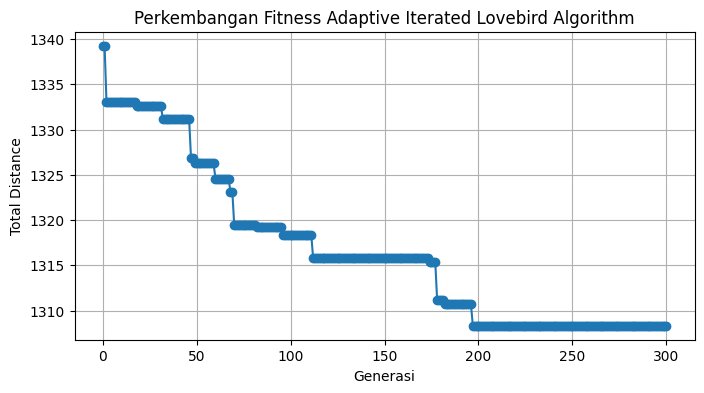

In [43]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_ail, marker='o')
plt.title("Perkembangan Fitness Adaptive Iterated Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

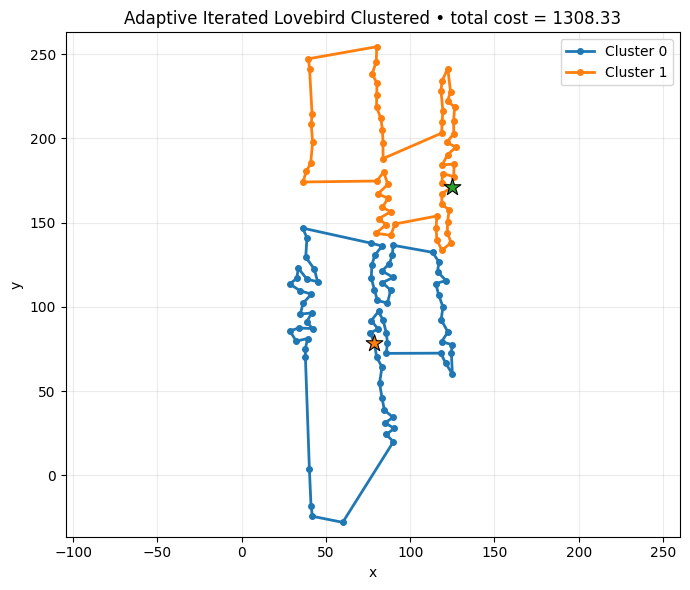

In [44]:
# --- contoh pakai hasil lovebird ---
plot_clustered_routes_matplotlib(
    best_sol_ail,
    show_ids=False,
    title=f"Adaptive Iterated Lovebird Clustered • total cost = {best_cost_ail:.2f}"
)

## AILS Debugging

In [45]:
def adaptive_iterated_lovebird_debug( 
    max_iter=300, 
    local_gen=3, 
    clusters=None,
    labels=None, nodes=None,
    initial_solution=None,
    seed=None,
    budget_s=None,
    init_mutations=20,
    patience=3,
    max_level=5,
    debug=False,          # NEW: flag debug
):
    if seed is not None:
        random.seed(seed)

    # --- siapkan solusi awal yang menghormati kluster ---
    def _init_solution_from_inputs():
        if clusters is not None:
            cur = [r[:] for r in clusters if len(r) > 0]
            return cur if cur else [[]]

        elif (labels is not None) and (nodes is not None):
            lab_arr = np.asarray(labels)
            K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
            tmp = {c: [] for c in range(K)}
            for n, l in zip(nodes, lab_arr):
                tmp[int(l)].append(n)

            # --- RANDOM urutan dalam tiap kluster ---
            cur = []
            for c in range(K):
                if tmp[c]:
                    r = tmp[c][:]        # copy node2 dalam cluster c
                    random.shuffle(r)    # acak urutan dalam kluster
                    cur.append(r)

            return cur if cur else [[]]

        elif initial_solution is not None:
            return [r[:] for r in initial_solution if len(r) > 0] or [[]]

        else:
            ids_copy = ids[:]
            random.shuffle(ids_copy)
            return [ids_copy]  # single-route fallback

    ls = two_opt_local_search

    # --- time budget helper (opsional) ---
    SAFETY   = 0.05
    t_start  = time.perf_counter()
    deadline = (t_start + budget_s) if (budget_s is not None) else None

    def time_left():
        return None if deadline is None else max(0.0, deadline - time.perf_counter())

    if debug:
        print("=== AILS START ===")
        print(f"max_iter={max_iter}, local_gen={local_gen}, "
              f"init_mutations={init_mutations}, patience={patience}, max_level={max_level}")
        if budget_s is not None:
            print(f"global_time_budget={budget_s} s")

    # =========================
    # 1) Solusi awal
    # =========================
    start_solution = _init_solution_from_inputs()
    if debug:
        init_cost = sum(total_distance(r) for r in start_solution)
        print(f"[INIT] initial solution cost = {init_cost:.4f}")

    rem = time_left()
    if rem is not None and rem <= SAFETY:
        best_sol = [r[:] for r in start_solution]
        best_cost = sum(total_distance(r) for r in best_sol)
        if debug:
            print("[EARLY RETURN] kehabisan waktu sebelum mutasi awal")
        return best_sol, float(best_cost), [float(best_cost)]

    # =========================
    # 2) FASE MUTASI LOVEBIRD (eksplorasi awal)
    # =========================
    best_seed = [r[:] for r in start_solution]
    best_seed_cost = sum(total_distance(r) for r in best_seed)

    lovebird_ops = [swap_two, flip, interchange, slide, guided_swap, scramble]

    if debug:
        t_mut_start = time.perf_counter()

    for m in range(1, init_mutations + 1):
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            if debug:
                print(f"[MUT] stop di m={m} karena time limit")
            break

        cand = [r[:] for r in start_solution]

        route_indices = [i for i, r in enumerate(cand) if len(r) >= 2]
        if not route_indices:
            if debug:
                print("[MUT] tidak ada rute yang bisa dimutasi")
            break

        v = random.choice(route_indices)
        route = cand[v][:]

        op = random.choice(lovebird_ops)

        if op is scramble:
            new_route = scramble(route)
        else:
            L = len(route)
            if L < 2:
                continue
            i, j = sorted(random.sample(range(L), 2))
            new_route = op(route, i, j)

        cand[v] = new_route
        cand_cost = sum(total_distance(r) for r in cand)

        if cand_cost < best_seed_cost - 1e-9:
            best_seed = cand
            best_seed_cost = cand_cost

        if debug and (m % 5 == 0 or m == 1):
            print(f"[MUT] m={m:2d} cand_cost={cand_cost:.2f} "
                  f"best_seed_cost={best_seed_cost:.2f}")

    if debug:
        t_mut_end = time.perf_counter()
        print(f"[MUT] selesai, best_seed_cost={best_seed_cost:.4f}, "
              f"time={(t_mut_end - t_mut_start):.3f}s")

    # =========================
    # 3) LS awal dari best_seed
    # =========================
    rem = time_left()
    if rem is not None and rem <= SAFETY:
        best_sol = [r[:] for r in best_seed]
        best_cost = sum(total_distance(r) for r in best_sol)
        if debug:
            print("[EARLY RETURN] kehabisan waktu sebelum LS awal")
        return best_sol, float(best_cost), [float(best_cost)]

    if debug:
        t_ls0_start = time.perf_counter()

    best_sol, best_cost, hist0, _ = ls(
        maxLoop=local_gen,
        clusters=best_seed,
        time_budget=(rem - SAFETY) if rem is not None else None
    )
    history = [best_cost]

    if debug:
        t_ls0_end = time.perf_counter()
        print(f"[LS0] cost={best_cost:.4f}, "
              f"ls_iters={len(hist0)-1}, time={(t_ls0_end - t_ls0_start):.3f}s")

    # =========================
    # 4) AILS loop: tingkat perturbasi adaptif
    # =========================
    no_improve = 0  # counter stagnasi

    for it in range(1, max_iter + 1):
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            if debug:
                print(f"[LOOP] stop di iter={it} karena time limit (rem={rem:.3f}s)")
            break

        best_before = best_cost
        stagn_before = no_improve

        # === pilih tingkat perturbasi berdasarkan stagnasi ===
        level = 1 + (no_improve // patience)
        if level > max_level:
            level = max_level

        # === perturbasi solusi terbaik sekarang ===
        t_iter_start = time.perf_counter()

        perturbed = [r[:] for r in best_sol]
        for _k in range(level):
            perturbed = double_bridge_multi(perturbed)

        if debug:
            pert_cost = sum(total_distance(r) for r in perturbed)

        rem = time_left()
        if rem is not None and rem <= SAFETY:
            if debug:
                print(f"[LOOP] stop di iter={it} setelah perturbasi (rem={rem:.3f}s)")
            break

        # === local search ===
        imp_sol, imp_cost, imp_hist, _ = ls(
            maxLoop=local_gen,
            clusters=perturbed,
            time_budget=(rem - SAFETY) if rem is not None else None
        )

        accepted = False
        if imp_cost < best_cost - 1e-9:
            best_sol = [r[:] for r in imp_sol]
            best_cost = imp_cost
            no_improve = 0
            accepted = True
        else:
            no_improve += 1

        history.append(best_cost)

        t_iter_end = time.perf_counter()
        iter_time = t_iter_end - t_iter_start

        if debug:
            rem_now = time_left()
            ls_iters = len(imp_hist) - 1
            print(
                f"iter={it:3d} "
                f"lvl={level} "
                f"stag_before={stagn_before:3d} "
                f"best_before={best_before:7.2f} "
                f"pert={pert_cost:7.2f} "
                f"imp={imp_cost:7.2f} "
                f"best_after={best_cost:7.2f} "
                f"acc={str(accepted):5s} "
                f"ls_iters={ls_iters:3d} "
                f"t_iter={iter_time:6.3f}s "
                f"rem={('None' if rem_now is None else f'{rem_now:6.3f}s')}"
            )

    if debug:
        total_time = time.perf_counter() - t_start
        print(f"=== AILS END === best_cost={best_cost:.4f}, total_time={total_time:.3f}s")

    return best_sol, float(best_cost), history


In [46]:
best_sol_ail, best_cost_ail, hist_ail = adaptive_iterated_lovebird_debug(
    max_iter=300, local_gen=3, patience=3,
    labels=labels, nodes=nodes, budget_s=None, debug=True
)

=== AILS START ===
max_iter=300, local_gen=3, init_mutations=20, patience=3, max_level=5
[INIT] initial solution cost = 7891.1041
[MUT] m= 1 cand_cost=7896.44 best_seed_cost=7891.10
[MUT] m= 5 cand_cost=7894.32 best_seed_cost=7815.34
[MUT] m=10 cand_cost=7898.55 best_seed_cost=7466.47
[MUT] m=15 cand_cost=7793.47 best_seed_cost=7466.47
[MUT] m=20 cand_cost=7745.14 best_seed_cost=7466.47
[MUT] selesai, best_seed_cost=7466.4696, time=0.001s
[LS0] cost=1350.1279, ls_iters=3, time=0.210s
iter=  1 lvl=1 stag_before=  0 best_before=1350.13 pert=1502.61 imp=1351.25 best_after=1350.13 acc=False ls_iters=  3 t_iter= 0.022s rem=None
iter=  2 lvl=1 stag_before=  1 best_before=1350.13 pert=1458.62 imp=1350.13 best_after=1350.13 acc=False ls_iters=  3 t_iter= 0.014s rem=None
iter=  3 lvl=1 stag_before=  2 best_before=1350.13 pert=1471.44 imp=1352.12 best_after=1350.13 acc=False ls_iters=  3 t_iter= 0.012s rem=None
iter=  4 lvl=2 stag_before=  3 best_before=1350.13 pert=1474.72 imp=1352.12 best_afte

# Testing

In [48]:
def benchmark_lovebird(
    N=10,
    budget_s=None,
    # argumen problem di-pass lewat kwargs:
    **problem_kwargs
):
    """
    Jalankan iterated_lovebird dan hyper_iterated_lovebird masing2 N kali,
    simpan best_cost dan runtime, lalu balikin DataFrame + plot boxplot.
    """
    results = []

    for run_id in range(N):
        seed = None  # supaya replikabel

        # --- ILS biasa ---
        t0 = time.perf_counter()
        _, cost_ils, _hist_ils = iterated_lovebird(
            max_iter=300, local_gen=3,
            init_mutations=30,
            budget_s=budget_s,
            seed=seed,
            **problem_kwargs
        )
        t1 = time.perf_counter()
        time_ils = t1 - t0

        results.append({
            "run": run_id,
            "algo": "ILS",
            "cost": float(cost_ils),
            "time_sec": float(time_ils),
        })

        # --- Hyper ILS ---
        t0 = time.perf_counter()
        _, cost_hils, _hist_hils = hyper_iterated_lovebird(
            max_iter=300, local_gen=3,
            patience=3,
            init_mutations=30,
            budget_s=budget_s,
            seed=seed,
            **problem_kwargs
        )
        t1 = time.perf_counter()
        time_hils = t1 - t0

        results.append({
            "run": run_id,
            "algo": "AILS",
            "cost": float(cost_hils),
            "time_sec": float(time_hils),
        })

    df = pd.DataFrame(results)
    return df


def plot_boxplots(df: pd.DataFrame):
    """
    Bikin dua boxplot:
    - distribusi cost
    - distribusi runtime (detik)
    """
    # --- Boxplot cost ---
    plt.figure()
    df.boxplot(column="cost", by="algo")
    plt.title("Distribusi Cost per Algoritma")
    plt.suptitle("")  # hilangkan judul default pandas
    plt.xlabel("Algoritma")
    plt.ylabel("Cost")
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)

    # --- Boxplot waktu ---
    plt.figure()
    df.boxplot(column="time_sec", by="algo")
    plt.title("Distribusi Runtime per Algoritma")
    plt.suptitle("")
    plt.xlabel("Algoritma")
    plt.ylabel("Waktu (detik)")
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)

    plt.show()


def print_stats(df: pd.DataFrame):
    """
    Cetak ringkasan statistik cost & runtime (mean, std, median, min, max)
    mirip yang kamu tulis sebelumnya.
    """
    for algo in sorted(df["algo"].unique()):
        sub = df[df["algo"] == algo]
        cost = sub["cost"]
        t = sub["time_sec"]

        cost_mean = cost.mean()
        cost_std  = cost.std(ddof=1)
        cost_med  = cost.median()
        cost_min  = cost.min()
        cost_max  = cost.max()

        t_mean = t.mean()
        t_std  = t.std(ddof=1)
        t_med  = t.median()
        t_min  = t.min()
        t_max  = t.max()

        print(f"{algo:<9}: cost {cost_mean:.2f}±{cost_std:.2f} "
              f"(med {cost_med:.2f}) [{cost_min:.2f}, {cost_max:.2f}] | "
              f"time {t_mean:.2f}±{t_std:.2f}s "
              f"(med {t_med:.2f}) [{t_min:.2f}, {t_max:.2f}]")


AILS     : cost 1311.23±3.50 (med 1310.40) [1306.28, 1317.28] | time 11.79±1.14s (med 11.62) [9.83, 13.32]
ILS      : cost 1315.07±5.38 (med 1314.12) [1305.83, 1326.60] | time 6.02±0.42s (med 6.05) [5.07, 6.59]


<Figure size 640x480 with 0 Axes>

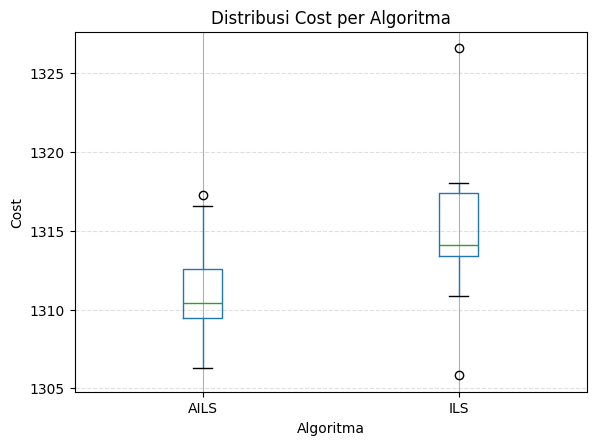

<Figure size 640x480 with 0 Axes>

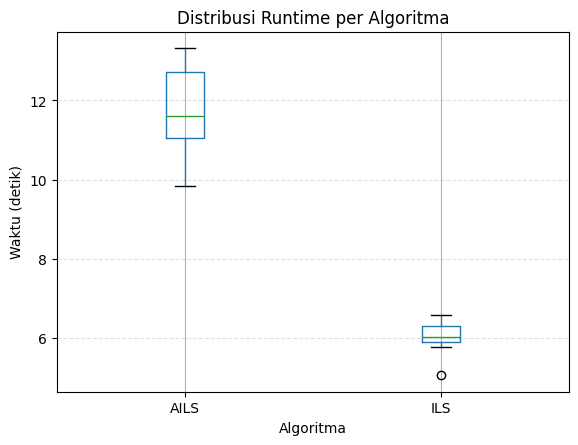

In [49]:
df = benchmark_lovebird(
    N=10,
    budget_s=None,      # atau None / nilai lain sesuai eksperimenmu
    labels=labels, nodes=nodes,
)

print_stats(df)     # ringkasan numerik
plot_boxplots(df)   # tampilkan boxplot